In [69]:
# Luca Soltero
import pandas as pd
import sqlite3

repo_dir = "your path here"
conn = sqlite3.connect(repo_dir)
curs = conn.cursor()
pd.set_option('display.max_columns', None)

qry = """WITH prelim AS (
    SELECT
        dir.dealid,
        dir.investorfundid,
        dir.InvestorInvestmentAmount,
        dir.NumberOfSharesAcquired AS NumberOfSharesAcquired_DIR,
        d.NumberOfSharesAcquired AS NumberOfSharesAcquired_D,
        d.PercentAcquired,
        d.DealSize,
        d.SeriesOfStock,
        d.DealDate,
        d.CompanyID,
        d.DealID
    FROM
        DealInvestorRelation dir
    LEFT JOIN
        Deal d ON dir.dealid = d.DealID
),
joined AS (
    SELECT
        p.dealid,
        p.investorfundid,
        p.InvestorInvestmentAmount,
        p.NumberOfSharesAcquired_DIR,
        p.NumberOfSharesAcquired_D,
        p.PercentAcquired,
        p.DealSize,
        p.DealDate,
        p.CompanyID,
        p.DealID,
        f.FundCountry,
        CASE
            WHEN p.SeriesOfStock LIKE '%Seed%' THEN 'Seed'
            WHEN p.SeriesOfStock LIKE '%A%' THEN 'A'
            WHEN p.SeriesOfStock LIKE '%B%' THEN 'B'
            WHEN p.SeriesOfStock LIKE '%C%' THEN 'C'
            WHEN p.SeriesOfStock LIKE '%D%' THEN 'D'
            WHEN p.SeriesOfStock LIKE '%E%' THEN 'E'
            WHEN p.SeriesOfStock LIKE '%F%' THEN 'F'
            WHEN p.SeriesOfStock LIKE '%G%' THEN 'G'
            ELSE 'Null'
        END AS SeedType
    FROM
        prelim p
    LEFT JOIN
        Fund f ON p.investorfundid = f.fundid
),
seed_investment_info AS (
    SELECT
        *,
        CASE
            WHEN InvestorInvestmentAmount IS NOT NULL THEN 1
            ELSE 0
        END AS HasInvestedAmount
    FROM
        joined
),
ranked_investments AS (
    SELECT
        *,
        ROW_NUMBER() OVER (PARTITION BY investorfundid, CompanyID ORDER BY DealDate) AS Rank
    FROM
        seed_investment_info
),
company_info AS (
    SELECT
        ri.*,
        c.companyid,
        c.GrowthRate,
        c.HQCountry
    FROM
        ranked_investments ri
    JOIN
        Company c ON ri.CompanyID = c.companyid
)
SELECT
    ci.*
FROM
    company_info ci
WHERE
    ci.InvestorInvestmentAmount IS NOT NULL
    AND ci.FundCountry = 'United States';"""
# query sample of interest

df = pd.read_sql_query(qry, conn)
df['DealDate'] = pd.to_datetime(df['DealDate'])
df.rename(columns={'NumberOfSharesAcquired': 'NumberOfSharesAcquired_DIR'}, inplace=True)

In [70]:
# calculate fund pa and total shares
df["TotalShares"] = (df["NumberOfSharesAcquired_D"]/df["PercentAcquired"]) * 100
df["FundPA"] = (df["NumberOfSharesAcquired_DIR"]/df["TotalShares"]) * 100
df["PredictedFundPA_0"] = (df["InvestorInvestmentAmount"]/df["DealSize"]) * df["PercentAcquired"]
print(df)

           dealid investorfundid  InvestorInvestmentAmount  \
0       10761-76T      11426-23F                  3.500000   
1       10696-15T      11260-09F                  3.500000   
2       39435-31T      11026-54F                  1.000000   
3       17185-96T      12629-53F                 18.000000   
4       11899-63T      11356-30F                  3.000000   
...           ...            ...                       ...   
27246  228240-10T      16953-67F                  0.049996   
27247  228240-10T      18476-83F                  0.049996   
27248  228240-10T      21198-07F                  1.499997   
27249   66234-43T      15460-30F                  0.200000   
27250  185047-30T      19172-35F                  0.125000   

       NumberOfSharesAcquired_DIR  NumberOfSharesAcquired_D  PercentAcquired  \
0                             NaN                       NaN              NaN   
1                             NaN                       NaN              NaN   
2              

In [71]:
# get averages for non-initial investment and initial investment, create individual dataframes

NFT = df[df["Rank"] != 1]
FT = df[df["Rank"] == 1]
print("Summary Non First pre Drop")
print(NFT["InvestorInvestmentAmount"].describe())
print("Summary First pre Drop")
print(FT["InvestorInvestmentAmount"].describe())

# drop values past 95%
percentile_95_NFT = NFT['InvestorInvestmentAmount'].quantile(0.95)
NFT = NFT[NFT['InvestorInvestmentAmount'] <= percentile_95_NFT]

percentile_95_FT = FT['InvestorInvestmentAmount'].quantile(0.95)
FT = FT[FT['InvestorInvestmentAmount'] <= percentile_95_NFT]

print("Summary Non First")
print(NFT["InvestorInvestmentAmount"].describe())
NFT_average = NFT["InvestorInvestmentAmount"].mean()

print("Summary First")
print(FT["InvestorInvestmentAmount"].describe())
FT_average = FT["InvestorInvestmentAmount"].mean()


Summary Non First pre Drop
count    5183.000000
mean        4.664240
std        76.885094
min         0.000000
25%         0.200000
50%         0.800000
75%         3.000000
max      5438.616328
Name: InvestorInvestmentAmount, dtype: float64
Summary First pre Drop
count    2.206800e+04
mean     4.145412e+02
std      6.058773e+04
min      0.000000e+00
25%      1.000000e-01
50%      3.000000e-01
75%      2.000000e+00
max      9.000184e+06
Name: InvestorInvestmentAmount, dtype: float64
Summary Non First
count    4926.000000
mean        1.826525
std         2.467064
min         0.000000
25%         0.180000
50%         0.700000
75%         2.500000
max        13.000000
Name: InvestorInvestmentAmount, dtype: float64
Summary First
count    20931.000000
mean         1.369076
std          2.380137
min          0.000000
25%          0.100000
50%          0.250000
75%          1.500000
max         13.000000
Name: InvestorInvestmentAmount, dtype: float64


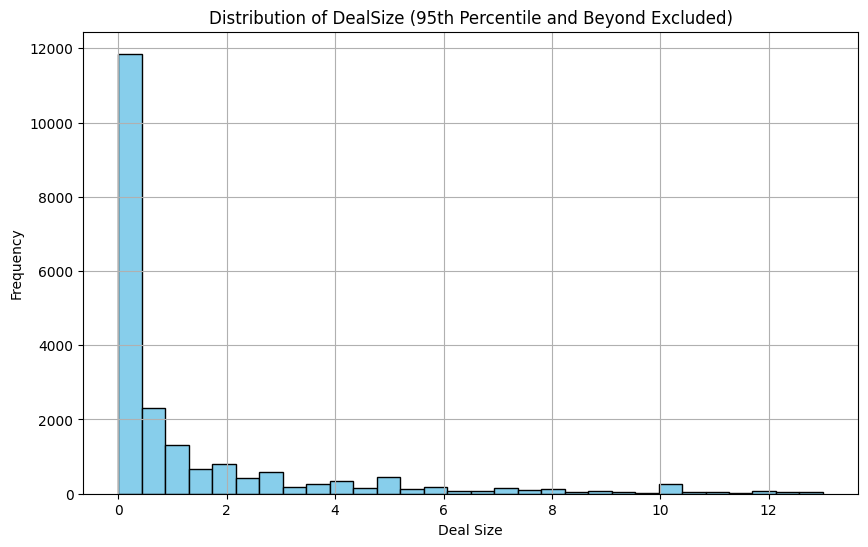

In [79]:
# plot distribution for both
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(FT["InvestorInvestmentAmount"], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Deal Size')
plt.ylabel('Frequency')
plt.title('Distribution of First Ticket (95th Percentile and Beyond Excluded)')
plt.grid(True)
plt.show()

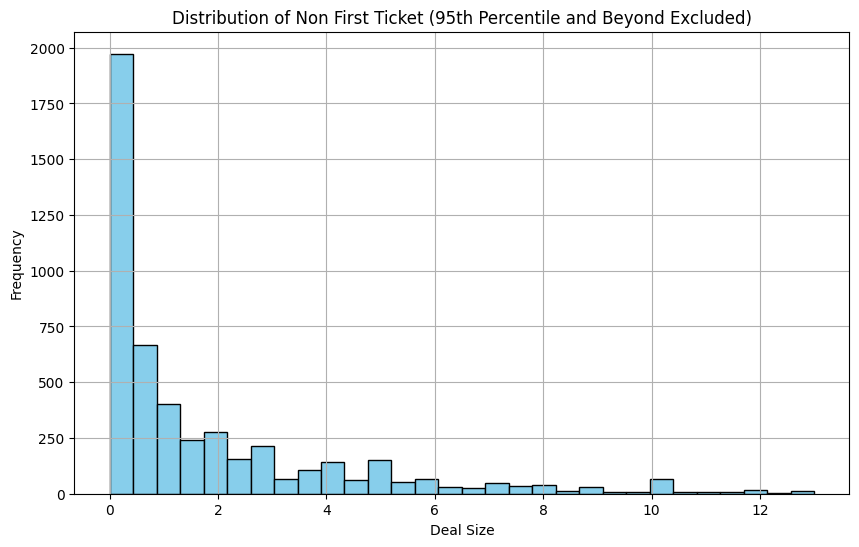

In [80]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(NFT["InvestorInvestmentAmount"], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Deal Size')
plt.ylabel('Frequency')
plt.title('Distribution of Non First Ticket (95th Percentile and Beyond Excluded)')
plt.grid(True)
plt.show()

In [72]:
# now we finetune for funding round. Iterate through seedtypes and get distribution of error from real values using this approach
seedList = ['None','Seed','A', 'B', 'C', 'E', 'F', 'G']
for seed in seedList:
    if seed == 'None':
        new = FT
    else:
        new = FT[FT["SeedType"] == seed]
    mean = new["InvestorInvestmentAmount"].mean()
    new = new.dropna(subset=["FundPA", "DealSize", "PercentAcquired"])
    new["PredictedAVG"] =  (mean/new["DealSize"]) * new["PercentAcquired"]
    new["AVG_error"] =  (new["PredictedAVG"] - new["FundPA"]).abs()
    print("Distribution of Error using Series ", seed, "Average")
    print(new["AVG_error"].describe())

Distribution of Error using Series  None Average
count    973.000000
mean      11.315207
std       34.065521
min        0.008883
25%        1.098352
50%        3.663771
75%       11.101330
max      498.040961
Name: AVG_error, dtype: float64
Distribution of Error using Series  Seed Average
count    56.000000
mean     10.407087
std       8.378779
min       0.457687
25%       3.983852
50%       7.122176
75%      15.191329
max      32.094827
Name: AVG_error, dtype: float64
Distribution of Error using Series  A Average
count    271.000000
mean       8.668331
std       10.321247
min        0.053269
25%        2.449952
50%        5.789139
75%       11.014903
max       71.729162
Name: AVG_error, dtype: float64
Distribution of Error using Series  B Average
count    184.000000
mean       3.710633
std        4.461993
min        0.023202
25%        0.950264
50%        2.215200
75%        4.570839
max       31.206668
Name: AVG_error, dtype: float64
Distribution of Error using Series  C Average
coun

/var/folders/f7/8j3xs5s170n8xsjr45rg2bzm0000gn/T/ipykernel_25609/2191909392.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new["PredictedAVG"] =  (mean/new["DealSize"]) * new["PercentAcquired"]
/var/folders/f7/8j3xs5s170n8xsjr45rg2bzm0000gn/T/ipykernel_25609/2191909392.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new["AVG_error"] =  (new["PredictedAVG"] - new["FundPA"]).abs()


In [73]:
# Now repeat for non first ticket

print(NFT["SeedType"].unique())


['B' 'D' 'Null' 'C' 'A' 'F' 'E' 'Seed' 'G']


In [77]:
# now we finetune for funding round. Iterate through seedtypes and get distribution of error from real values using this approach
seedList = ['None','Seed','A', 'B','C','D','E', 'F', 'G']
for seed in seedList:
    if seed =='None':
        new = NFT
    else:
        new = NFT[NFT["SeedType"] == seed]
    mean = new["InvestorInvestmentAmount"].mean()
    new = new.dropna(subset=["FundPA", "DealSize", "PercentAcquired"])
    new["PredictedAVG"] =  (mean/new["DealSize"]) * new["PercentAcquired"]
    new["AVG_error"] =  (new["PredictedAVG"] - new["FundPA"]).abs()
    print("Distribution of Error using Series ", seed, "Average")
    print(new["AVG_error"].describe())

Distribution of Error using Series  None Average
count    386.000000
mean       6.245812
std       16.148942
min        0.001998
25%        0.586573
50%        1.849799
75%        5.751685
max      152.948403
Name: AVG_error, dtype: float64
Distribution of Error using Series  Seed Average
count     8.000000
mean     10.735563
std       8.785637
min       3.425351
25%       4.191454
50%       5.494292
75%      19.298085
max      23.842838
Name: AVG_error, dtype: float64
Distribution of Error using Series  A Average
count    90.000000
mean      5.676509
std       5.038197
min       0.045666
25%       2.243633
50%       4.579641
75%       7.371754
max      25.982541
Name: AVG_error, dtype: float64
Distribution of Error using Series  B Average
count    71.000000
mean      3.243958
std       3.897245
min       0.044037
25%       0.715813
50%       2.096221
75%       3.607226
max      15.981772
Name: AVG_error, dtype: float64
Distribution of Error using Series  C Average
count    62.000000
m

/var/folders/f7/8j3xs5s170n8xsjr45rg2bzm0000gn/T/ipykernel_25609/4123980358.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new["PredictedAVG"] =  (mean/new["DealSize"]) * new["PercentAcquired"]
/var/folders/f7/8j3xs5s170n8xsjr45rg2bzm0000gn/T/ipykernel_25609/4123980358.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new["AVG_error"] =  (new["PredictedAVG"] - new["FundPA"]).abs()


In [75]:
conn.close()